# B08705012 胡家愷 HW5

In [32]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Read Dataset

Label =  blazer


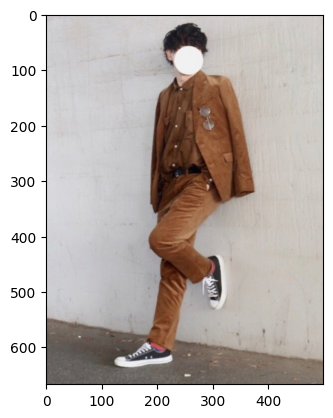

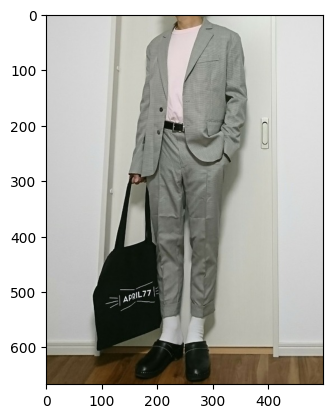

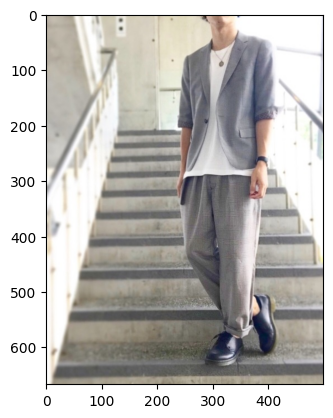

Label =  cardigan


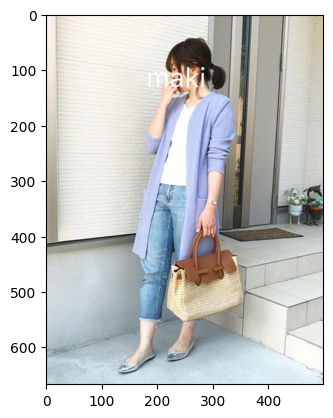

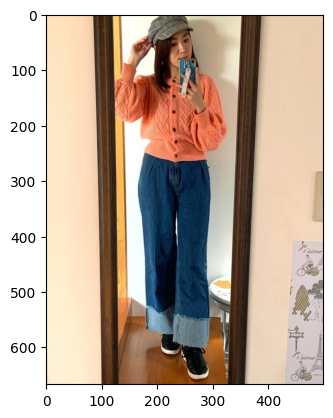

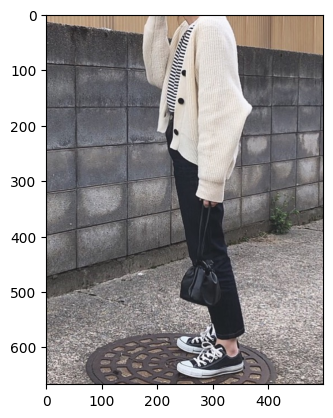

Label =  coat


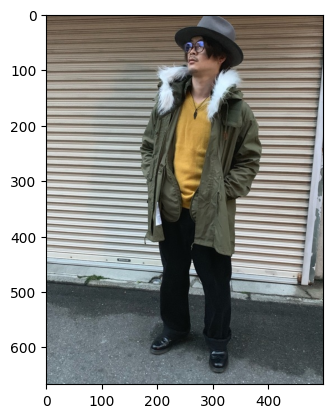

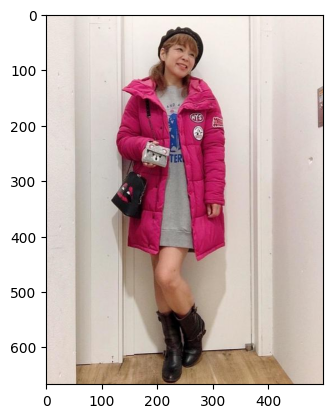

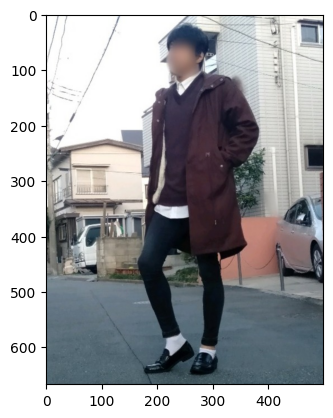

Label =  jacket


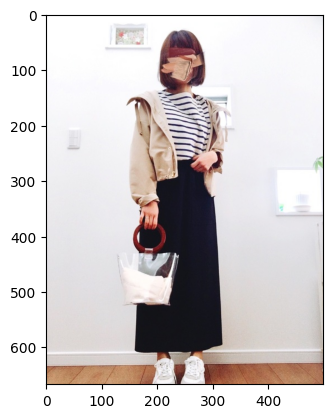

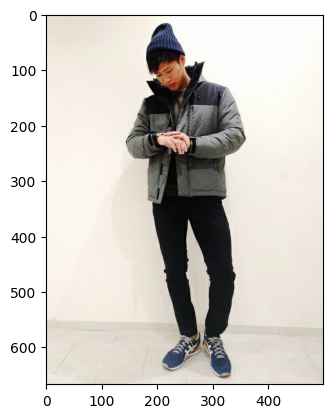

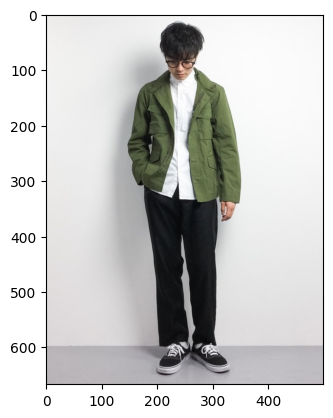

In [33]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join("photos/train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

In [34]:
import pandas as pd
import numpy as np
import torch

In [37]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cpu')

## Q1
列出train, valid, test的總照片數，以及各類別的照片數與比率。

In [38]:
def printDatasetReport(basepath="photos/train"):
    labels = ['blazer', 'cardigan', 'coat', 'jacket', "Total"]
    label_cnt = [0, 0, 0, 0, 0]
    for i in range(4):
        joinpath = os.path.join(basepath, labels[i], "*.jpg")
        cand_fn = glob.glob(joinpath)
        label_cnt[i] = len(cand_fn)
    label_cnt[4] = sum(label_cnt)
    print("Total number of images in ", basepath, " = ", label_cnt[4])
    print("Number of images per label")
    df = pd.DataFrame({'label': labels, 'count': label_cnt})
    df['ratio'] = df['count'] / label_cnt[4] * 100
    df['ratio'] = df['ratio'].apply(lambda x: str("%.2f" % x) + '%')
    display(df)

In [39]:
printDatasetReport("photos/train")

Total number of images in  photos/train  =  1041
Number of images per label


,label,count,ratio
0,blazer,97,9.32%
1,cardigan,237,22.77%
2,coat,296,28.43%
3,jacket,411,39.48%
4,Total,1041,100.00%


In [40]:
printDatasetReport("photos/valid")

Total number of images in  photos/valid  =  105
Number of images per label


,label,count,ratio
0,blazer,7,6.67%
1,cardigan,36,34.29%
2,coat,27,25.71%
3,jacket,35,33.33%
4,Total,105,100.00%


In [41]:
printDatasetReport("photos/test")

Total number of images in  photos/test  =  146
Number of images per label


,label,count,ratio
0,blazer,9,6.16%
1,cardigan,42,28.77%
2,coat,43,29.45%
3,jacket,52,35.62%
4,Total,146,100.00%


我們預期模型在看過比較多照片愈能夠準確辨識，因此在訓練集中各類別比例由高到低依序是 jacket > coat > cardigan > blazer，我們也預期各類別的準確率會是 **jacket > coat > cardigan > blazer**

## Q2
### Data processing
- 解析度調整(Resize)成較短邊為256像素的照片
- 隨機取大小為224x224的影像
- 隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度
- 依照 Pretrained ResNet 的要求調整RGB的均數與標準差
- 測試資料 (Valid and Test) 亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

In [42]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, basepath, transform=None):
        self.basepath = basepath
        self.transform = transform
        self.labels = ['blazer', 'cardigan', 'coat', 'jacket']
        self.label2idx = {'blazer': 0, 'cardigan': 1, 'coat': 2, 'jacket': 3}
        self.imgs = []
        for i in range(4):
            joinpath = os.path.join(basepath, self.labels[i], "*.jpg")
            cand_fn = glob.glob(joinpath)
            for afn in cand_fn:
                self.imgs.append((afn, i))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        afn, label = self.imgs[idx]
        img = Image.open(afn)
        if self.transform:
            img = self.transform(img)
        return img, label

In [46]:
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

preprocess_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [56]:
dataset_train = Dataset("photos/train", transform=preprocess_train)
dataset_valid = Dataset("photos/valid", transform=preprocess_test)
dataset_test = Dataset("photos/test", transform=preprocess_test)

In [57]:
dataset_train[0][0].shape

torch.Size([3, 224, 224])

In [58]:
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

### Model Construction
- Resnet50
- 最後一層的Fully Connected Layer 輸出維度改成 4
- 使用 torchvision 提供的pretrained weights (torchvision.models.resnet50(pretrained=True))初始化模型權重。
- Early Stopping的Patient參數設為 20 Epochs。
- Batch size 設為 32。
- 每一個 Epoch 計算一次 Valid Loss，並記錄 Valid Loss 最低的模型。
- 模型訓練最多200個Epochs。
- 使用最佳模型在test資料計算模型 Accuracy, Confusion Matrix, 與 Per-class Accuracy。
- 考慮 SGD 與 ADAM 兩種最佳化演算法。

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [59]:
def train(model, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=10, model_path="model.pth", verbose=True):
    best_epoch = 0
    best_valid_loss = 1e10
    for epoch in range(num_epochs):
        model.train()
        for i, (imgs, labels) in enumerate(dataloader_train):
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        valid_loss = 0
        correct_cnt = 0
        for i, (imgs, labels) in enumerate(dataloader_valid):
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct_cnt += torch.sum(preds == labels.data)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
        valid_loss /= len(dataloader_valid)
        accuracy = correct_cnt / len(dataloader_valid.dataset)
        if verbose:
            print("Epoch %d, valid loss = %.4f, accuracy = %.4f" % (epoch+1, valid_loss, accuracy))
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_path)
        
        # Early stopping
        if epoch - best_epoch > 20:
            print(f"Early stopping at epoch {epoch}")
            break
    print(f"Valid loss: {best_valid_loss}")

In [63]:
from sklearn.metrics import classification_report
def test(model, dataloader, criterion):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        total_correct = 0
        total_cnt = 0
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            total_correct += torch.sum(preds == labels.data)
            total_cnt += imgs.size(0)
            y_true.extend(labels.data.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
        avg_acc = total_correct.double() / total_cnt
        print("Accuracy = %.4f" % avg_acc)
        print(classification_report(y_true, y_pred, target_names=dataset_test.labels))
        # calculate per class accuracy
        print("Per class accuracy:")
        for i in range(4):
            total_cnt = np.sum(np.array(y_true) == i)
            correct_cnt = np.sum((np.array(y_true) == i) & (np.array(y_pred) == i))
            print("Accuracy of %5s : %2d %%" % (dataset_test.labels[i], 100 * correct_cnt / total_cnt))

### Use SGD

In [65]:
import torchvision.models as models

learning_rates = [0.01, 0.005, 0.001, 0.0005, 0.0001]
for lr in learning_rates:
    print(f"Learning rate: {lr}")
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = torch.nn.Linear(2048, 4)
    resnet50 = resnet50.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9)

    train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=5, model_path=f"q2_sgd_{str(lr)}.ckpt")

Epoch 0, valid loss = 1.2228, accuracy = 0.4000
Epoch 1, valid loss = 1.1350, accuracy = 0.4000
Epoch 2, valid loss = 2.9962, accuracy = 0.3238
Epoch 3, valid loss = 1.4889, accuracy = 0.3810
Epoch 4, valid loss = 2.1906, accuracy = 0.4286


### Use Adam

In [ ]:
for lr in learning_rates:
    resnet50 = models.resnet50(pretrained=True)
    resnet50.fc = torch.nn.Linear(2048, 4)
    resnet50 = resnet50.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr)

    train(resnet50, dataloader_train, dataloader_valid, criterion, optimizer, num_epochs=5, model_path=f"q2_adam_{str(lr)}.ckpt")

### 選擇 ...

In [ ]:
# load the best model
resnet50.load("q2_sgd_0.001.ckpt")
# use best model to test
test(resnet50, dataloader_test, criterion)